In this ipython notebook, we will load data from other ipython notebook and process them so that we know

1. how many people cross border everyday?
2. what are their destinations and home?
3. conver data to formats for plotings like time series and sankey graph.

In [2]:
import pandas as pd
import csv
import numpy as np
from scripts.geocoding import *
from scripts.preprocessing import *
import pickle
import time
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [9]:
with open('data/twitter-swisscom/user_info_total.pickle', 'rb') as f:
    uId_x_followers_friends = pickle.load(f)
    
with open('data/twitter-swisscom/geo_info_total.pickle', 'rb') as f:
    pId_x_lat_lng = pickle.load(f)
    
with open('data/twitter-swisscom/pId_geo_df_total.pickle', 'rb') as f:
    pId_x_geo = pickle.load(f)

In [18]:
with open('data/twitter-swisscom/create_twitter_total.pickle', 'rb') as f:
    total_df = pickle.load(f)

In [174]:
total_df.reset_index(inplace=True)

In [176]:
df_sample = total_df[:5000].copy()

In [25]:
# Example
from itertools import groupby

def remove_consecutive_in_list(l):
    return [x[0] for x in groupby(l)]

def unique_index_consecutive_in_list(l):
    return [x[0] for x in groupby(l)]

In [234]:
# Convert pytime to time
df_sample['time'] = df_sample['createdAt'].apply(lambda x: pd.Timestamp(x).to_pydatetime())

In [238]:
c =total_df.iloc[0]

In [241]:
t = time.time()
total_df['time_id'] = total_df.apply(lambda x: str(x['createdAt'])[:10], axis=1)
print("time = ", time.time() - t)

time =  582.1858599185944


In [245]:
total_df.head()

1,index,userId,createdAt,placeId,weekday,day,hour,month,time_id
0,0,30445147,2013-04-24 01:42:07,508f024bc856afc5,2,24,1,4,2013-04-24
1,1,1136150214,2013-04-24 01:42:39,d969dab4efecff93,2,24,1,4,2013-04-24
2,2,853308949,2013-04-24 01:42:44,a573c842499b9471,2,24,1,4,2013-04-24
3,3,1136150214,2013-04-24 01:43:01,d969dab4efecff93,2,24,1,4,2013-04-24
4,4,1136150214,2013-04-24 01:44:13,d969dab4efecff93,2,24,1,4,2013-04-24


In [246]:
total_df_m    = total_df[['userId', 'placeId', 'time_id']]
gp_total_df_m = total_df_m.groupby(['time_id', 'userId'])

In [248]:
# make a dataframe of (date, user) as index, (placeId, time) as column
# remove all the twitters whose locations are the same to the previous one.
timeId_userId_x_placeId_total_df = gp_total_df_m.aggregate(lambda x: tuple(x.loc[x.shift() != x]))

### Consider people who have at least two locations in a day

For this part, we reduce the dataset to people who have moved in a day.
Further, we will pay special interest to people who have crossed the border.

In [252]:
people_movement_total_df = timeId_userId_x_placeId_total_df[timeId_userId_x_placeId_total_df.apply(
        lambda x: len(x['placeId']) > 1, axis=1)].copy()

In [279]:
missing_data = [l for l in pId_x_lat_lng.placeId if l not in pId_x_geo.index]

In [315]:
def placeId_to_country(pId_df, pId):
    if pId in pId_df.index:
        return pId_df.loc[pId]['country_code']
    else:
        return 'ignore'
    
def placeId_to_state(pId_df, pId):
    if pId in pId_df.index:
        return pId_df.loc[pId]['state']
    else:
        return 'ignore'

In [304]:
# Be careful that there are 'ignored' countries in this dataframe
people_movement_total_df['country_list'] = people_movement_total_df['placeId'].apply(
    lambda x: [placeId_to_country(pId_x_geo, i) for i in x])

In [316]:
# Be careful that there are 'ignored' countries in this dataframe
people_movement_total_df['state_list'] = people_movement_total_df['placeId'].apply(
    lambda x: [placeId_to_state(pId_x_geo, i) for i in x])

Select people who has crossed country border in a day

In [321]:
people_across_country_total_df = people_movement_total_df[
    people_movement_total_df.apply(lambda x: len(set(x['country_list'])) > 1, axis=1)].copy()

In [326]:
people_across_country_total_df['country_list'] = people_across_country_total_df['country_list'].apply(
    lambda x: remove_consecutive_in_list(x))

In [498]:
def date():
    def foo():
        c1 = collections.defaultdict(int)
        c2 = collections.defaultdict(int)
        return {'from_ch': c1, 'to_ch':c2}
    return collections.defaultdict(foo)

In [499]:
cross_country_with_time = date()

def add_adj_country(l, date):
    for i in range(len(l)-1):
        if none_to_ignore(l[i]) == 'ch':
            cross_country_with_time[date]['from_ch'][none_to_ignore(l[i+1])] += 1
        elif none_to_ignore(l[i+1]) == 'ch':
            cross_country_with_time[date]['to_ch'][none_to_ignore(l[i])] += 1

In [500]:
for time_idx  in people_across_country_total_df.index:
    add_adj_country(people_across_country_total_df.loc[time_idx]['country_list'], time_idx[0])

In [501]:
import json
with open("data/twitter-swisscom/time_country_dictionary.json", "w") as h:
    json.dump(cross_country_with_time, h)

In [507]:
fr = [cross_country_with_time[i]['to_ch']['fr'] for i in cross_country_with_time.keys()]

In [509]:
import matplotlib.pylab as plt
%matplotlib inline

In [528]:
cross_country_with_time['2014-01-02']['from_ch']

defaultdict(int, {'at': 207, 'de': 790, 'fr': 1053, 'ignore': 10, 'it': 633})

In [525]:
cross_country_with_time['2014-01-02']['to_ch']

defaultdict(int, {'at': 228, 'de': 844, 'fr': 1072, 'ignore': 5, 'it': 652})

2013-12-08 Immaculate Conception day

2014-01-02 Berchtoldstag day

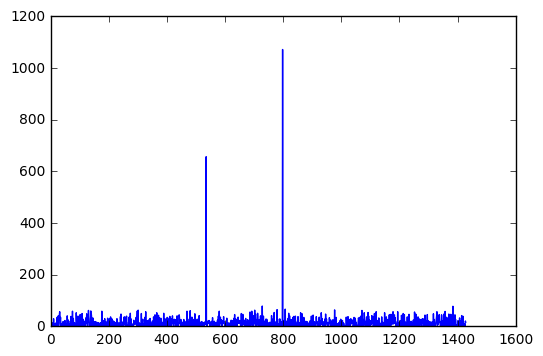

In [531]:
plt.plot(fr)
plt.show()

In [537]:
cross_country_with_time['2014-01-02']['to_ch']

defaultdict(int, {'at': 228, 'de': 844, 'fr': 1072, 'ignore': 5, 'it': 652})

### To sankey graph

Transform data to fit into sankey graph's requirement

In [621]:
def to_sanky_node_link_list(to_ch, from_ch):
    all_countries = list(from_ch.keys())
    all_countries.extend(list(to_ch.keys()))
    all_countries = np.unique(all_countries)
    all_countries = all_countries[all_countries != 'ignore']
    
    node_list = [{"name":'ch'}]
    node_list.extend([{"name": i} for i in all_countries])
    index = {name: i + 1 for i, name in enumerate(all_countries)}
    node_list.extend([{"name":'ch'}])
    
    link_list = []
    l = from_ch
    for i in l.keys():
        if i != 'ignore':
            link_list.append({"source":0, "target":index[i], "value":l[i]})

    l = to_ch
    for i in l.keys():
        if i != 'ignore':
            link_list.append({"source":index[i], "target":len(node_list)-1, "value":l[i]})  
    return link_list, node_list

In [625]:
sankey = {}
for key in cross_country_with_time.keys():
    to_ch = cross_country_with_time[key]['to_ch']
    from_ch = cross_country_with_time[key]['from_ch']
    link_list, node_list = to_sanky_node_link_list(to_ch, from_ch)
    sankey[key] = {}
    sankey[key]['nodes'] = node_list
    sankey[key]['link']  = link_list

In [626]:
with open("data/twitter-swisscom/sankey_data.json", "w") as f:
    json.dump(sankey, f)